# 08 - Snapshotting with Devito using the `ConditionalDimension`

This notebook intends to introduce new Devito users (especially with a C or FORTRAN background) to the best practice on saving snapshots to disk, as a binary float file. 

We start by presenting a naive approach, and then introduce a more efficient method, which exploits Devito's  `ConditionalDimension`.

# Initialize utilities

In [1]:
#NBVAL_IGNORE_OUTPUT
%reset -f
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Problem Setup 
This tutorial is based on an example that has appeared in a [TLE tutorial](https://github.com/devitocodes/devito/blob/main/examples/seismic/tutorials/01_modelling.ipynb)(Louboutin et. al., 2017), in which one shot is modeled over a 2-layer velocity model.

Operator `initdamp` ran in 0.01 s


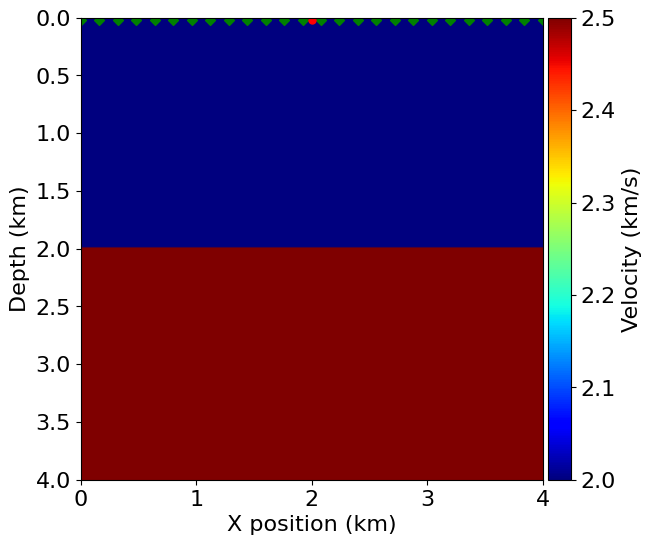

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0035219999999999987, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0003080000000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.00036299999999999977, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [2]:
# This cell sets up the problem that is already explained in the first TLE tutorial.

#NBVAL_IGNORE_OUTPUT
#%%flake8
from examples.seismic import Receiver
from examples.seismic import RickerSource
from examples.seismic import Model, plot_velocity, TimeAxis
from devito import TimeFunction
from devito import Eq, solve
from devito import Operator


# Set velocity model
nx = 201
nz = 201
nb = 10
shape = (nx, nz)
spacing = (20., 20.)
origin = (0., 0.)
v = np.empty(shape, dtype=np.float32)
v[:, :int(nx/2)] = 2.0
v[:, int(nx/2):] = 2.5

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation lasts tn milliseconds
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(
    name='src',
    grid=model.grid,
    f0=f0,
    time_range=time_range)

src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

rec = Receiver(
    name='rec',
    grid=model.grid,
    npoint=101,
    time_range=time_range)  # new
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m
depth = rec.coordinates.data[:, 1]  # Depth is 20m


plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

#Used for reshaping
vnx = nx+20
vnz = nz+20

# Set symbolics for the wavefield object `u`, setting save on all time steps
# (which can occupy a lot of memory), to later collect snapshots (naive method):

u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)

# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)
op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

# Run the operator for `(nt-2)` time steps:
op(time=nt-2, dt=model.critical_dt)


# Saving snaps to disk - naive approach

We want to get equally spaced snaps from the `nt-2` saved in `u.data`. The user can then define the total number of snaps `nsnaps`, which determines a `factor` to divide `nt`.

In [3]:
nsnaps = 100
factor = round(u.shape[0] / nsnaps)  # Get approx nsnaps, for any nt
ucopy = u.data.copy(order='C')
filename = "naivsnaps.bin"
file_u = open(filename, 'wb')
for it in range(0, nsnaps):
    file_u.write(ucopy[it*factor, :, :])
file_u.close()

Checking `u.data` spaced by `factor` using matplotlib,

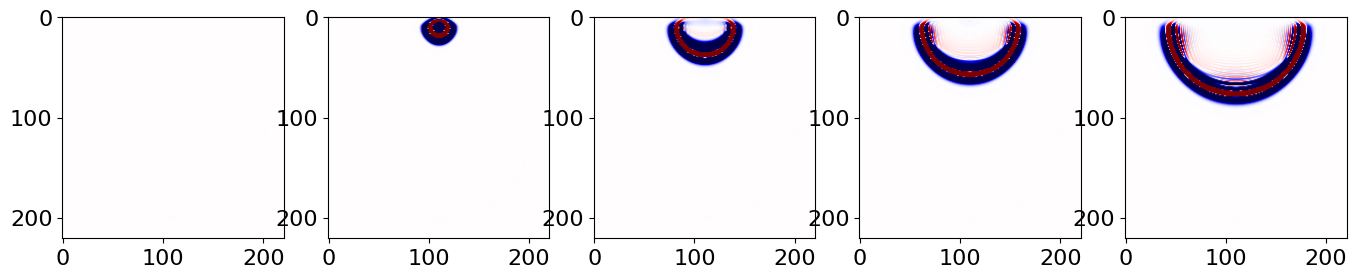

In [4]:
#NBVAL_IGNORE_OUTPUT
plt.rcParams['figure.figsize'] = (20, 20)  # Increases figure size

imcnt = 1 # Image counter for plotting
plot_num = 5 # Number of images to plot

for i in range(0, nsnaps, int(nsnaps/plot_num)):
    plt.subplot(1, plot_num+1, imcnt+1)
    imcnt = imcnt + 1
    plt.imshow(np.transpose(u.data[i * factor, :, :]), vmin=-1, vmax=1, cmap="seismic")

plt.show()


Or from the saved file:


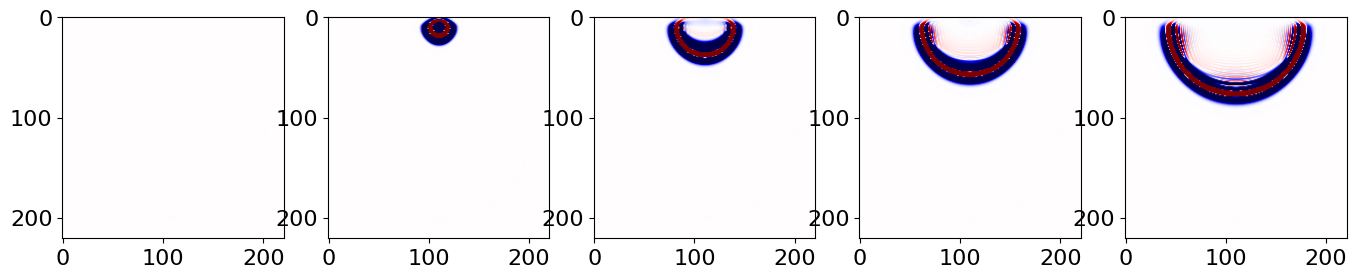

In [5]:
#NBVAL_IGNORE_OUTPUT
fobj = open("naivsnaps.bin", "rb")
snaps = np.fromfile(fobj, dtype = np.float32)
snaps = np.reshape(snaps, (nsnaps, vnx, vnz)) #reshape vec2mtx, devito format. nx first
fobj.close()

plt.rcParams['figure.figsize'] = (20,20) # Increases figure size

imcnt = 1 # Image counter for plotting
plot_num = 5 # Number of images to plot

for i in range(0, nsnaps, int(nsnaps/plot_num)):
   plt.subplot(1, plot_num+1, imcnt+1)
   imcnt = imcnt + 1
   plt.imshow(np.transpose(snaps[i,:,:]), vmin=-1, vmax=1, cmap="seismic")

plt.show()

This C/FORTRAN way of saving snaps is clearly not optimal when using Devito; the wavefield object `u` is specified to save all snaps, and a memory copy is done at every `op` time step. Giving that we don't want all the snaps saved, this process is wasteful; only the selected snapshots should be copied during execution. 


To address these issues, a better way to save snaps using Devito's capabilities is presented in the following section.

# Saving snaps to disk - Devito method

A better way to save snapshots to disk is to create a new `TimeFunction`, `usave`, whose time size is equal to 
`nsnaps`. There are 3 main differences from the previous code, which are flagged by `#Part 1`, `#Part 2` and `#Part 3` . After running the code each part is explained with more detail.

In [6]:
#NBVAL_IGNORE_OUTPUT
from devito import ConditionalDimension

nsnaps = 103            # desired number of equally spaced snaps
factor = round(nt / nsnaps)  # subsequent calculated factor

print(f"factor is {factor}")

#Part 1 #############
time_subsampled = ConditionalDimension(
    't_sub', parent=model.grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=2,
                     save=nsnaps, time_dim=time_subsampled)
print(time_subsampled)
#####################

u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(
    field=u.forward,
    expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

#Part 2 #############
op1 = Operator([stencil] + src_term + rec_term,
               subs=model.spacing_map)  # usual operator
op2 = Operator([stencil] + src_term + [Eq(usave, u)] + rec_term,
               subs=model.spacing_map)  # operator with snapshots

op1(time=nt - 2, dt=model.critical_dt)  # run only for comparison
u.data.fill(0.)
op2(time=nt - 2, dt=model.critical_dt)
#####################

#Part 3 #############
print("Saving snaps file")
print(f"Dimensions: nz = {nz + 2 * nb:d}, nx = {nx + 2 * nb:d}")
filename = "snaps2.bin"
usave.data.tofile(filename)
#####################

factor is 2
t_sub


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Saving snaps file
Dimensions: nz = 221, nx = 221


As `usave.data` has the desired snaps, no extra variable copy is required. The snaps can then be visualized:

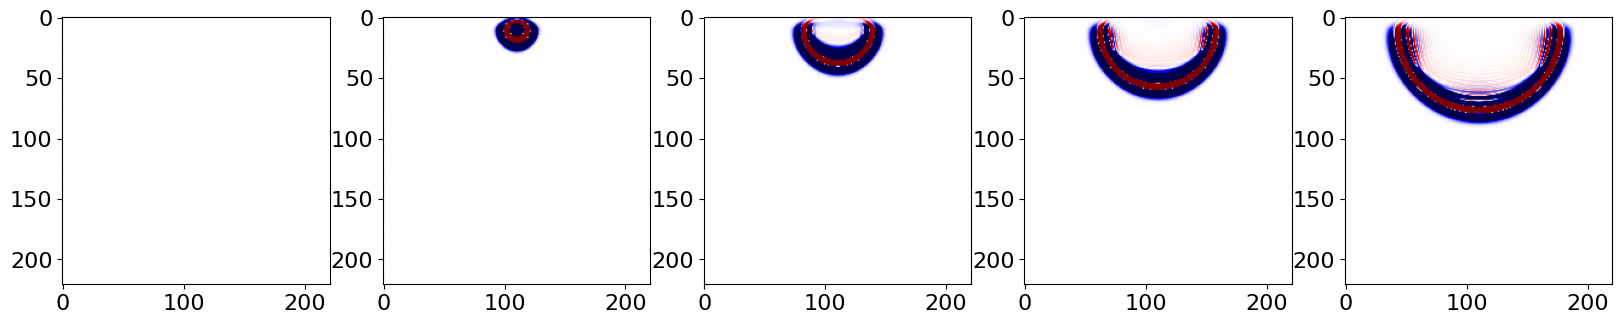

In [7]:
#NBVAL_IGNORE_OUTPUT
fobj = open("snaps2.bin", "rb")
snaps = np.fromfile(fobj, dtype=np.float32)
snaps = np.reshape(snaps, (nsnaps, vnx, vnz))
fobj.close()

plt.rcParams['figure.figsize'] = (20, 20)  # Increases figure size

imcnt = 1 # Image counter for plotting
plot_num = 5 # Number of images to plot
for i in range(0, plot_num):
   plt.subplot(1, plot_num, i+1)
   imcnt = imcnt + 1
   ind = i * int(nsnaps/plot_num)
   plt.imshow(np.transpose(snaps[ind,:,:]), vmin=-1, vmax=1, cmap="seismic")

plt.show()

## About Part 1

Here a subsampled version (`time_subsampled`) of the full time Dimension (`model.grid.time_dim`) is created with the `ConditionalDimension`. `time_subsampled` is then used to define an additional symbolic wavefield `usave`, which will store in `usave.data` only the predefined number of snapshots (see Part 2).

Further insight on how `ConditionalDimension` works and its most common uses can be found in [the Devito documentation](https://www.devitoproject.org/devito/dimension.html#devito.types.dimension.ConditionalDimension). The following excerpt exemplifies subsampling of simple functions:

    Among the other things, ConditionalDimensions are indicated to implement
    Function subsampling. In the following example, an Operator evaluates the
    Function ``g`` and saves its content into ``f`` every ``factor=4`` iterations.
    
    >>> from devito import Dimension, ConditionalDimension, Function, Eq, Operator
    >>> size, factor = 16, 4
    >>> i = Dimension(name='i')
    >>> ci = ConditionalDimension(name='ci', parent=i, factor=factor)
    >>> g = Function(name='g', shape=(size,), dimensions=(i,))
    >>> f = Function(name='f', shape=(int(size/factor),), dimensions=(ci,))
    >>> op = Operator([Eq(g, 1), Eq(f, g)])
    
    The Operator generates the following for-loop (pseudocode)
    .. code-block:: C
        for (int i = i_m; i <= i_M; i += 1) {
          g[i] = 1;
          if (i%4 == 0) {
            f[i / 4] = g[i];
          }
        }

From this excerpt we can see that the C code generated by `Operator` with the extra argument `Eq(f,g)` mainly corresponds to adding an `if` block on the optimized C-code, which saves the desired snapshots on `f`, from `g`, at the correct times. Following the same line of thought, in the following section the symbolic and C-generated code are compared, with and without snapshots.

# About Part 2
        
We then define `Operator`s `op1` (no snaps) and `op2` (with snaps). The only difference between the two is that `op2` has an extra symbolic equation `Eq(usave, u)`. Notice that even though `usave` and `u` have different Dimensions, Devito's symbolic interpreter understands it, because `usave`'s `time_dim` was defined through the `ConditionalDimension`. 

Below, we show relevant excerpts of the compiled `Operators`. As explained above, the main difference between the optimized C-code of `op1` and `op2` is the addition of an `if` block. For `op1`'s C code:

```c
// #define's
//...

// declare dataobj struct
//...

// declare profiler struct
//...

int Kernel(struct dataobj *restrict damp_vec, const float dt, struct dataobj *restrict m_vec, const float o_x, const float o_y, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int p_rec_M, const int p_rec_m, const int p_src_M, const int p_src_m, const int time_M, const int time_m, struct profiler * timers)
{
  // ...
  // ...
    
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;
  // ...
  
  for (int time = time_m, t0 = (time)%(3), t1 = (time + 1)%(3), t2 = (time + 2)%(3); time <= time_M; time += 1, t0 = (time)%(3), t1 = (time + 1)%(3), t2 = (time + 2)%(3))
  {
    struct timeval start_section0, end_section0;
    gettimeofday(&start_section0, NULL);
    for (int x = x_m; x <= x_M; x += 1)
    {
      #pragma omp simd
      for (int y = y_m; y <= y_M; y += 1)
      {
        float r0 = 1.0e+4F*dt*m[x + 2][y + 2] + 5.0e+3F*(dt*dt)*damp[x + 1][y + 1];
        u[t1][x + 2][y + 2] = 2.0e+4F*dt*m[x + 2][y + 2]*u[t0][x + 2][y + 2]/r0 - 1.0e+4F*dt*m[x + 2][y + 2]*u[t2][x + 2][y + 2]/r0 + 1.0e+2F*((dt*dt*dt)*u[t0][x + 1][y + 2]/r0 + (dt*dt*dt)*u[t0][x + 2][y + 1]/r0 + (dt*dt*dt)*u[t0][x + 2][y + 3]/r0 + (dt*dt*dt)*u[t0][x + 3][y + 2]/r0) + 5.0e+3F*(dt*dt)*damp[x + 1][y + 1]*u[t2][x + 2][y + 2]/r0 - 4.0e+2F*dt*dt*dt*u[t0][x + 2][y + 2]/r0;
      }
    }
    gettimeofday(&end_section0, NULL);
    timers->section0 += (double)(end_section0.tv_sec-start_section0.tv_sec)+(double)(end_section0.tv_usec-start_section0.tv_usec)/1000000;
    struct timeval start_section1, end_section1;
    gettimeofday(&start_section1, NULL);
    for (int p_src = p_src_m; p_src <= p_src_M; p_src += 1)
    {
        //source injection
        //...
    }
    gettimeofday(&end_section1, NULL);
    timers->section1 += (double)(end_section1.tv_sec-start_section1.tv_sec)+(double)(end_section1.tv_usec-start_section1.tv_usec)/1000000;
    struct timeval start_section2, end_section2;
    gettimeofday(&start_section2, NULL);
    for (int p_rec = p_rec_m; p_rec <= p_rec_M; p_rec += 1)
    {
         //receivers interpolation
         //...
    }
    gettimeofday(&end_section2, NULL);
    timers->section2 += (double)(end_section2.tv_sec-start_section2.tv_sec)+(double)(end_section2.tv_usec-start_section2.tv_usec)/1000000;
  }
  return 0;
}
```

`op2`'s C code (differences are highlighted by `//<<<<<<<<<<<<<<<<<<<<`):

```c
// #define's
//...

// declare dataobj struct
//...

// declare profiler struct
//...

int Kernel(struct dataobj *restrict damp_vec, const float dt, struct dataobj *restrict m_vec, const float o_x, const float o_y, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict usave_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int p_rec_M, const int p_rec_m, const int p_src_M, const int p_src_m, const int time_M, const int time_m, struct profiler * timers)
{
  // ...
  // ...
    
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;
//<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<DECLARE USAVE<<<<<<<<<<<<<<<<<<<<<    
  float (*restrict usave)[usave_vec->size[1]][usave_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[usave_vec->size[1]][usave_vec->size[2]]) usave_vec->data;
//<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<    
    
    //flush denormal numbers...
    
  for (int time = time_m, t0 = (time)%(3), t1 = (time + 1)%(3), t2 = (time + 2)%(3); time <= time_M; time += 1, t0 = (time)%(3), t1 = (time + 1)%(3), t2 = (time + 2)%(3))
  {
    struct timeval start_section0, end_section0;
    gettimeofday(&start_section0, NULL);
    for (int x = x_m; x <= x_M; x += 1)
    {
      #pragma omp simd
      for (int y = y_m; y <= y_M; y += 1)
      {
        float r0 = 1.0e+4F*dt*m[x + 2][y + 2] + 5.0e+3F*(dt*dt)*damp[x + 1][y + 1];
        u[t1][x + 2][y + 2] = 2.0e+4F*dt*m[x + 2][y + 2]*u[t0][x + 2][y + 2]/r0 - 1.0e+4F*dt*m[x + 2][y + 2]*u[t2][x + 2][y + 2]/r0 + 1.0e+2F*((dt*dt*dt)*u[t0][x + 1][y + 2]/r0 + (dt*dt*dt)*u[t0][x + 2][y + 1]/r0 + (dt*dt*dt)*u[t0][x + 2][y + 3]/r0 + (dt*dt*dt)*u[t0][x + 3][y + 2]/r0) + 5.0e+3F*(dt*dt)*damp[x + 1][y + 1]*u[t2][x + 2][y + 2]/r0 - 4.0e+2F*dt*dt*dt*u[t0][x + 2][y + 2]/r0;
      }
    }
    gettimeofday(&end_section0, NULL);
    timers->section0 += (double)(end_section0.tv_sec-start_section0.tv_sec)+(double)(end_section0.tv_usec-start_section0.tv_usec)/1000000;
//<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<SAVE SNAPSHOT<<<<<<<<<<<<<<<<<<<<<
    if ((time)%(60) == 0)
    {
      struct timeval start_section1, end_section1;
      gettimeofday(&start_section1, NULL);
      for (int x = x_m; x <= x_M; x += 1)
      {
        #pragma omp simd
        for (int y = y_m; y <= y_M; y += 1)
        {
          usave[time / 60][x + 2][y + 2] = u[t0][x + 2][y + 2];
        }
      }
//<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
      gettimeofday(&end_section1, NULL);
      timers->section1 += (double)(end_section1.tv_sec-start_section1.tv_sec)+(double)(end_section1.tv_usec-start_section1.tv_usec)/1000000;
    }
    struct timeval start_section2, end_section2;
    gettimeofday(&start_section2, NULL);
    for (int p_src = p_src_m; p_src <= p_src_M; p_src += 1)
    {
        //source injection
        //...
    }
    gettimeofday(&end_section2, NULL);
    timers->section2 += (double)(end_section2.tv_sec-start_section2.tv_sec)+(double)(end_section2.tv_usec-start_section2.tv_usec)/1000000;
    struct timeval start_section3, end_section3;
    gettimeofday(&start_section3, NULL);
    for (int p_rec = p_rec_m; p_rec <= p_rec_M; p_rec += 1)
    {
        //receivers interpolation
        //...
    }
    gettimeofday(&end_section3, NULL);
    timers->section3 += (double)(end_section3.tv_sec-start_section3.tv_sec)+(double)(end_section3.tv_usec-start_section3.tv_usec)/1000000;
  }
  return 0;
}

```

To inspect the full codes of `op1` and `op2`, run the block below:

In [8]:
def print2file(filename, thingToPrint):
    import sys

    orig_stdout = sys.stdout

    f = open(filename, 'w')
    sys.stdout = f
    print(thingToPrint)
    f.close()

    sys.stdout = orig_stdout


# print2file("op1.c", op1)  # uncomment to print to file
# print2file("op2.c", op2)  # uncomment to print to file
# print(op1) # uncomment to print here
# print(op2) # uncomment to print here

To run snaps as a movie (outside Jupyter Notebook), run the code below, altering `filename, nsnaps, nx, nz` accordingly:

In [9]:
#NBVAL_IGNORE_OUTPUT
#NBVAL_SKIP
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

filename = "naivsnaps.bin"
nsnaps = 100
fobj = open(filename, "rb")
snapsObj = np.fromfile(fobj, dtype=np.float32)
snapsObj = np.reshape(snapsObj, (nsnaps, vnx, vnz))
fobj.close()

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
matrice = ax.imshow(snapsObj[0, :, :].T, vmin=-1, vmax=1, cmap="seismic")
plt.colorbar(matrice)

plt.xlabel('x')
plt.ylabel('z')
plt.title('Modelling one shot over a 2-layer velocity model with Devito.')

def update(i):
    matrice.set_array(snapsObj[i, :, :].T)
    return matrice,

# Animation
ani = animation.FuncAnimation(fig, update, frames=nsnaps, interval=50, blit=True)

plt.close(ani._fig)
HTML(ani.to_html5_video())


# References

Louboutin, M., Witte, P., Lange, M., Kukreja, N., Luporini, F., Gorman, G., & Herrmann, F. J. (2017). Full-waveform inversion, Part 1: Forward modeling. The Leading Edge, 36(12), 1033-1036.